Iniciando proceso con backbone permanentemente congelado...
Creando transformaciones de data augmentation...
Inicializando StanfordDogsDataset...
Preparando Stanford Dogs dataset...
StanfordDogsDataset preparado con 20580 muestras.
Cargando dataset de 9Breeds...
Inicializando NineBreedsDataset...
df_breed con 21624 muestras.

df_emotion con 15921 muestras.

Usando dispositivo: cuda
Dividiendo el dataset...
Train: 15136, Val: 4325, Test: 2163
Creando BreedDataset...
BreedDataset con 15136 muestras. 125 clases de raza.
Creando BreedDataset...
BreedDataset con 4325 muestras. 125 clases de raza.
Creando BreedDataset...
BreedDataset con 2163 muestras. 125 clases de raza.
Creando BreedClassifierResNet con backbone congelado, dropout = 0.5

Iniciando entrenamiento con backbone congelado...

=== Época 1/30 ===
Train Loss: 3.3956 | Val Loss: 1.6011
Learning Rate actual: 0.000500
=== Época 2/30 ===
Train Loss: 1.6933 | Val Loss: 0.9646
Learning Rate actual: 0.000500
=== Época 3/30 ===
Train Loss

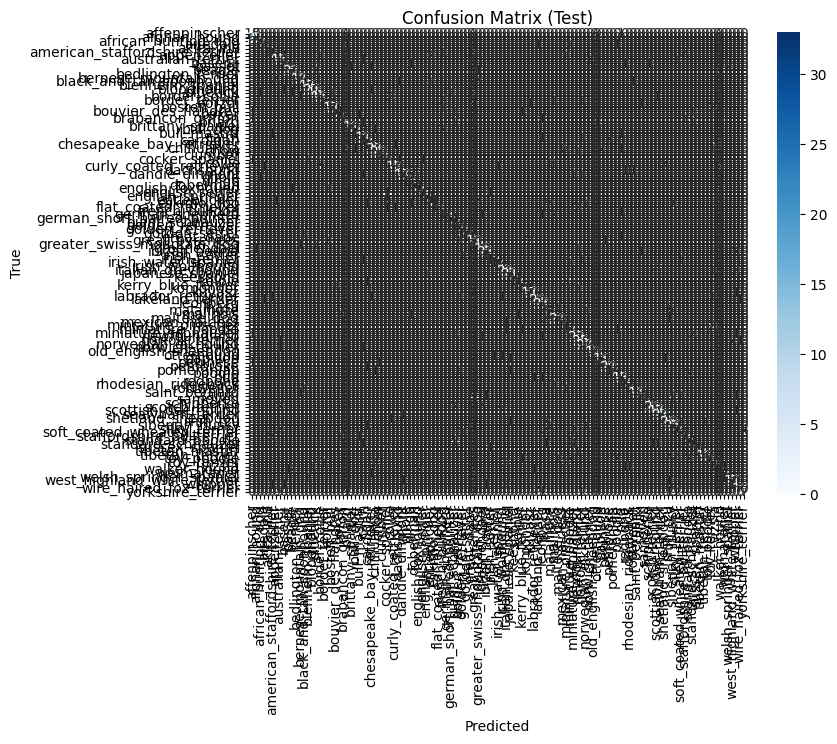

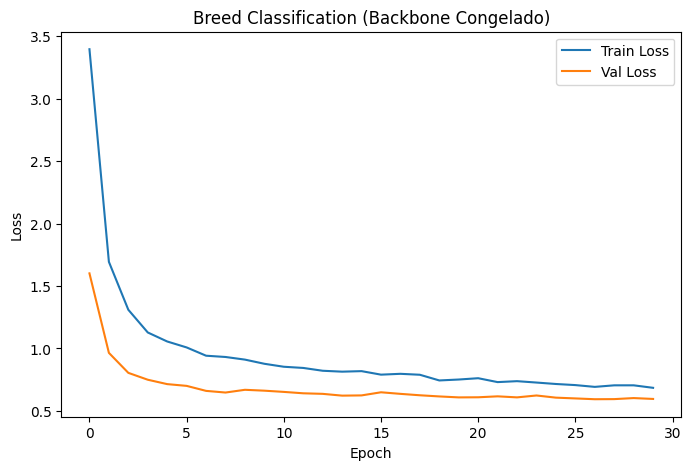

Modelo de razas (backbone congelado) guardado en: models\resnet50_breed_frozen.pth

Dividiendo el dataset...
Train: 11144, Val: 3184, Test: 1593
Creando EmotionDataset...
EmotionDataset con 11144 muestras, 4 clases de emoción.
Creando EmotionDataset...
EmotionDataset con 3184 muestras, 4 clases de emoción.
Creando EmotionDataset...
EmotionDataset con 1593 muestras, 4 clases de emoción.
Creando EmotionClassifierResNet con backbone congelado, dropout = 0.5

Iniciando entrenamiento con backbone congelado...

=== Época 1/30 ===
Train Loss: 1.2561 | Val Loss: 1.1762
Learning Rate actual: 0.000500
=== Época 2/30 ===
Train Loss: 1.1897 | Val Loss: 1.1601
Learning Rate actual: 0.000500
=== Época 3/30 ===
Train Loss: 1.1712 | Val Loss: 1.1630
Learning Rate actual: 0.000500
=== Época 4/30 ===
Train Loss: 1.1568 | Val Loss: 1.1450
Learning Rate actual: 0.000500
=== Época 5/30 ===
Train Loss: 1.1499 | Val Loss: 1.1422
Learning Rate actual: 0.000500
=== Época 6/30 ===
Train Loss: 1.1505 | Val Loss:

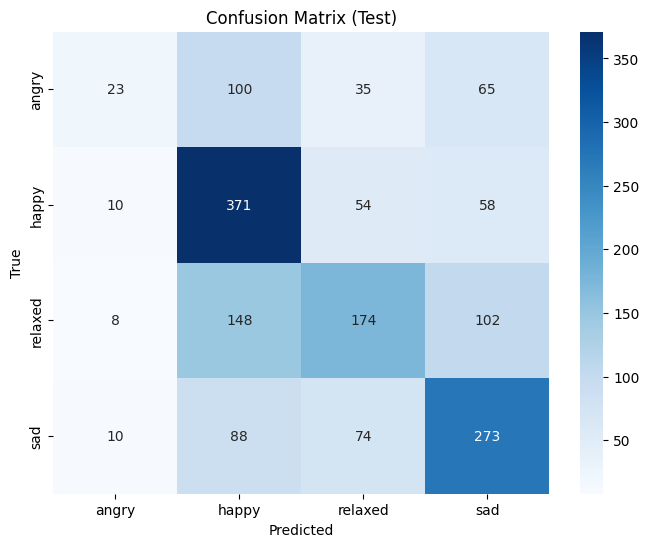

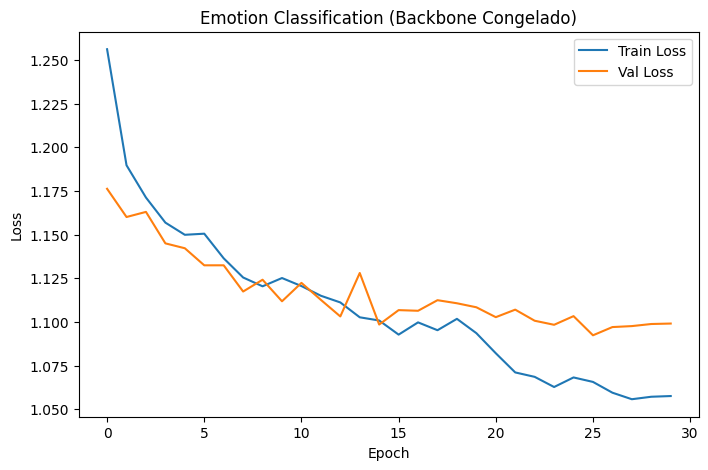

Modelo de emociones (backbone congelado) guardado en: models\resnet50_emotion_frozen.pth

Proceso completo finalizado con backbone permanentemente congelado. ¡Éxito!


In [3]:
import os
import glob
import copy
import pandas as pd
import numpy as np
from PIL import Image
import xml.etree.ElementTree as ET  # Para parsear bounding boxes
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import datasets, models, transforms
from torchvision.models import ResNet50_Weights

# -----------------------------------------------------------------------------
#                              CONFIGURACIONES
# -----------------------------------------------------------------------------
SEED = 20
torch.manual_seed(SEED)
np.random.seed(SEED)

# -----------------------------------------------------------------------------
#                               DATASETS
# -----------------------------------------------------------------------------

class StanfordDogsDataset(Dataset):
    """
    Dataset específico para Stanford Dogs:
      - Verifica que cada imagen cuente con su archivo XML.
      - Parseamos el XML para recortar la imagen al bounding box principal.
      - Devolvemos la imagen (opcionalmente transformada) y la etiqueta de raza.
    """
    def __init__(self, images_dir, annotations_dir, transform=None):
        print("Inicializando StanfordDogsDataset...")
        self.images_dir = os.path.normpath(images_dir)
        self.annotations_dir = os.path.normpath(annotations_dir)
        self.transform = transform

        self.data = []
        self.labels = []
        self._prepare_dataset()

    def _prepare_dataset(self):
        print("Preparando Stanford Dogs dataset...")

        image_paths = []
        for ext in ['*.jpg', '*.jpeg', '*.png']:
            image_paths.extend(glob.glob(os.path.join(self.images_dir, '*', ext)))

        for img_path in image_paths:
            img_path = os.path.normpath(img_path)
            breed_folder = os.path.basename(os.path.dirname(img_path))
            image_name = os.path.splitext(os.path.basename(img_path))[0]

            if '-' in breed_folder:
                clean_breed = '-'.join(breed_folder.split('-')[1:])
            else:
                clean_breed = breed_folder

            ann_path = os.path.join(self.annotations_dir, breed_folder, f"{image_name}.xml")
            ann_path = os.path.normpath(ann_path)

            if not os.path.exists(ann_path):
                print(f"Anotación faltante para la imagen: {img_path}")
                continue

            self.data.append((img_path, ann_path, clean_breed))
            self.labels.append(clean_breed)

        print(f"StanfordDogsDataset preparado con {len(self.data)} muestras.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, ann_path, breed_label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        image = self._crop_to_bounding_box(image, ann_path)

        if self.transform:
            image = self.transform(image)

        return image, breed_label

    def _crop_to_bounding_box(self, image, ann_path):
        try:
            tree = ET.parse(ann_path)
            root = tree.getroot()
            obj = root.find('object')
            if obj is not None:
                bndbox = obj.find('bndbox')
                if bndbox is not None:
                    xmin = int(bndbox.find('xmin').text)
                    ymin = int(bndbox.find('ymin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymax = int(bndbox.find('ymax').text)

                    xmin = max(0, xmin)
                    ymin = max(0, ymin)
                    width, height = image.size
                    xmax = min(xmax, width)
                    ymax = min(ymax, height)

                    if (xmax > xmin) and (ymax > ymin):
                        image = image.crop((xmin, ymin, xmax, ymax))
        except Exception as e:
            print(f"Error al parsear {ann_path}: {e}")
        return image


class NineBreedsDataset(Dataset):
    """
    Dataset análogo para 9Breeds. Emplea ImageFolder internamente.
    """
    def __init__(self, folder_path, transform=None):
        print("Inicializando NineBreedsDataset...")
        self.folder_path = os.path.normpath(folder_path)
        self.transform = transform

        self.imagefolder = datasets.ImageFolder(root=self.folder_path)
        self.idx_to_class = {v: k for k, v in self.imagefolder.class_to_idx.items()}
        self.samples = self.imagefolder.samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, class_idx = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        class_name = self.idx_to_class[class_idx]
        return image, class_name


class BreedDataset(Dataset):
    """
    Dataset unificado para razas (tras convertir a DataFrame ['image', 'Breed']).
    """
    def __init__(self, dataframe, transform=None):
        print("Creando BreedDataset...")
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

        self.breed_set = sorted(set(self.dataframe['Breed'].dropna()))
        self.breed_to_idx = {b: i for i, b in enumerate(self.breed_set)}
        self.idx_to_breed = {i: b for b, i in self.breed_to_idx.items()}

        print(f"BreedDataset con {len(self.dataframe)} muestras. "
              f"{len(self.breed_set)} clases de raza.")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['image']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        breed_label = self.breed_to_idx.get(row['Breed'], -1)
        if breed_label == -1:
            raise ValueError(f"Raza desconocida: {row['Breed']} en idx {idx}")

        return image, breed_label


class EmotionDataset(Dataset):
    """
    Dataset para clasificación de emociones. Recibe un DataFrame con columnas ['image', 'Emotion'].
    """
    def __init__(self, dataframe, transform=None):
        print("Creando EmotionDataset...")
        df_filtered = dataframe[dataframe['Emotion'].notna()].reset_index(drop=True)
        self.dataframe = df_filtered
        self.transform = transform

        self.emotion_set = sorted(set(self.dataframe['Emotion'].dropna()))
        self.emotion_to_idx = {emo: i for i, emo in enumerate(self.emotion_set)}
        self.idx_to_emotion = {i: emo for emo, i in self.emotion_to_idx.items()}

        print(f"EmotionDataset con {len(self.dataframe)} muestras, "
              f"{len(self.emotion_set)} clases de emoción.")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['image']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        emotion_label = self.emotion_to_idx.get(row['Emotion'], -1)
        return image, emotion_label


# -----------------------------------------------------------------------------
#                          FUNCIONES AUXILIARES
# -----------------------------------------------------------------------------

def load_nine_breeds_dog_breeds(nine_breeds_path, transform=None):
    print("Cargando dataset de 9Breeds...")
    ds = NineBreedsDataset(folder_path=nine_breeds_path, transform=transform)
    return ds


def get_transforms():
    """
    Data Augmentation: RandomResizedCrop, flips, rotations, color jitter, etc.
    """
    print("Creando transformaciones de data augmentation...")
    return transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])


def split_dataset(df, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, seed=SEED):
    print("Dividiendo el dataset...")
    train_df, temp_df = train_test_split(df, train_size=train_ratio, random_state=seed)
    val_size = val_ratio / (val_ratio + test_ratio)
    val_df, test_df = train_test_split(temp_df, train_size=val_size, random_state=seed)
    print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)


def compute_class_weights(labels, num_classes):
    """
    Calcula pesos inversos a la frecuencia de cada clase.
    """
    class_counts = np.bincount(labels, minlength=num_classes)
    total_samples = len(labels)
    weights = total_samples / (num_classes * class_counts)
    return weights


# -----------------------------------------------------------------------------
#                          MODELOS
# -----------------------------------------------------------------------------

class BreedClassifierResNet(nn.Module):
    def __init__(self, num_breeds, dropout_p=0.5):
        super().__init__()
        print("Creando BreedClassifierResNet con backbone congelado, dropout =", dropout_p)
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        # Congelar todas las capas del backbone
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Reemplazar la FC final y entrenar solo esta parte
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(256, num_breeds)
        )

    def forward(self, x):
        return self.resnet(x)


class EmotionClassifierResNet(nn.Module):
    """
    ResNet50 para clasificar emociones, *backbone congelado* y solo la FC entrenable.
    """
    def __init__(self, num_emotions, dropout_p=0.5):
        super().__init__()
        print("Creando EmotionClassifierResNet con backbone congelado, dropout =", dropout_p)
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        for param in self.resnet.parameters():
            param.requires_grad = False

        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(256, num_emotions)
        )

    def forward(self, x):
        return self.resnet(x)


# -----------------------------------------------------------------------------
#           ENTRENAMIENTO (SIN DESCONGELAR EL BACKBONE EN NINGÚN MOMENTO)
# -----------------------------------------------------------------------------

def train_classification_model(model, train_loader, val_loader, class_names,
                               device='cuda', epochs=30, early_stopping_patience=10,
                               lr=0.0005, weight_decay=1e-4, scheduler_factor=0.75):
    """
    Entrena un modelo de clasificación con:
      - Backbone congelado (no se descongela en ningún momento).
      - Optimizador Adam (lr=0.0005).
      - ReduceLROnPlateau con factor=0.75.
      - Early Stopping con patience=5.
    """
    print("\nIniciando entrenamiento con backbone congelado...\n")
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss(ignore_index=-1)

    # Se elimina 'verbose=True' para evitar la advertencia
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=scheduler_factor, patience=3
    )

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        print(f"=== Época {epoch+1}/{epochs} ===")
        # Fase de entrenamiento
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Fase de validación
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Ajustar LR según scheduler
        scheduler.step(avg_val_loss)

        # (Opcional) Mostrar la LR actual sin 'verbose'
        current_lr = scheduler.optimizer.param_groups[0]['lr']
        print(f"Learning Rate actual: {current_lr:.6f}")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print(f"[EARLY STOPPING] No mejora en val_loss tras {early_stopping_patience} épocas.")
                break

    model.load_state_dict(best_model_wts)
    print("Entrenamiento finalizado. Modelo restaurado a los mejores pesos.\n")
    return train_losses, val_losses



def evaluate_classification_model(model, test_loader, class_names, device='cuda'):
    print("Evaluando en conjunto de TEST...\n")

    model.to(device)
    model.eval()

    preds, true_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1).cpu().numpy()
            preds.extend(predicted)
            true_labels.extend(labels.numpy())

    print("Classification Report (Test):")
    print(classification_report(true_labels, preds, target_names=class_names, zero_division=0))

    cm = confusion_matrix(true_labels, preds, labels=range(len(class_names)))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Test)')
    plt.show()


def plot_losses(train_losses, val_losses, title):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# -----------------------------------------------------------------------------
#                                MAIN
# -----------------------------------------------------------------------------

def main():
    print("Iniciando proceso con backbone permanentemente congelado...")

    stanford_images_path = './datasets/stanford_breeds/Images'
    stanford_annotations_path = './datasets/stanford_breeds/Annotation'
    nine_breeds_path = './datasets/9Breeds'
    emotion_path = './datasets/dogs_emotions'
    model_dir = 'models'
    os.makedirs(model_dir, exist_ok=True)

    # Transformaciones
    transform = get_transforms()

    # 1) Cargar Stanford Dogs y 9Breeds
    stanford_dataset = StanfordDogsDataset(images_dir=stanford_images_path,
                                           annotations_dir=stanford_annotations_path,
                                           transform=None)

    nine_breeds_dataset = load_nine_breeds_dog_breeds(nine_breeds_path, transform=None)

    # 2) Unificar en df_breed
    breed_images_stanford = [img_path for (img_path, _, c_breed) in stanford_dataset.data]
    breed_labels_stanford = stanford_dataset.labels
    breed_images_9b = [path for (path, _) in nine_breeds_dataset.samples]
    breed_labels_9b = [nine_breeds_dataset.idx_to_class[idx] for (_, idx) in nine_breeds_dataset.samples]

    breed_images = breed_images_stanford + breed_images_9b
    breed_labels = breed_labels_stanford + breed_labels_9b

    breed_labels_clean = [b.lower().replace('-', '_').replace(' ', '_') for b in breed_labels]
    df_breed = pd.DataFrame({'image': breed_images, 'Breed': breed_labels_clean})
    print(f"df_breed con {len(df_breed)} muestras.\n")

    # 3) Dataset de emociones
    emotion_dataset = datasets.ImageFolder(root=emotion_path)
    emotion_images = [os.path.normpath(img_path) for (img_path, _) in emotion_dataset.samples]
    emotion_labels_raw = [emotion_dataset.classes[idx] for (_, idx) in emotion_dataset.samples]
    emotion_labels_clean = [e.lower().replace(' ', '_') for e in emotion_labels_raw]
    df_emotion = pd.DataFrame({'image': emotion_images, 'Emotion': emotion_labels_clean})
    print(f"df_emotion con {len(df_emotion)} muestras.\n")

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Usando dispositivo: {device}")

    # -------------------------------------------------------------------------
    # Entrenamiento Modelo de RAZAS (backbone congelado todo el tiempo)
    # -------------------------------------------------------------------------
    train_df_breed, val_df_breed, test_df_breed = split_dataset(
        df_breed, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, seed=SEED
    )

    train_dataset_breed = BreedDataset(train_df_breed, transform=transform)
    val_dataset_breed = BreedDataset(val_df_breed, transform=transform)
    test_dataset_breed = BreedDataset(test_df_breed, transform=transform)

    # (Opcional) WeightedRandomSampler
    breed_train_labels = [lbl for _, lbl in train_dataset_breed]
    breed_class_weights = compute_class_weights(
        labels=breed_train_labels,
        num_classes=len(train_dataset_breed.breed_set)
    )
    samples_weights = [breed_class_weights[lbl] for lbl in breed_train_labels]
    weighted_sampler_breed = WeightedRandomSampler(weights=samples_weights,
                                                   num_samples=len(samples_weights),
                                                   replacement=True)

    use_weighted_breed = False 
    if use_weighted_breed:
        train_loader_breed = DataLoader(train_dataset_breed, batch_size=64,
                                        sampler=weighted_sampler_breed,
                                        num_workers=0)
    else:
        train_loader_breed = DataLoader(train_dataset_breed, batch_size=64, shuffle=True, num_workers=0)

    val_loader_breed = DataLoader(val_dataset_breed, batch_size=64, shuffle=False, num_workers=0)
    test_loader_breed = DataLoader(test_dataset_breed, batch_size=64, shuffle=False, num_workers=0)

    # Modelo 
    model_breed = BreedClassifierResNet(
        num_breeds=len(train_dataset_breed.breed_set),
        dropout_p=0.5
    )

    breed_train_losses, breed_val_losses = train_classification_model(
        model_breed,
        train_loader_breed,
        val_loader_breed,
        class_names=train_dataset_breed.breed_set,
        device=device,
        epochs=30,  
        early_stopping_patience=10,
        lr=0.0005,
        weight_decay=1e-4,
        scheduler_factor=0.75
    )

    # Evaluar
    evaluate_classification_model(model_breed, test_loader_breed,
                                  class_names=train_dataset_breed.breed_set,
                                  device=device)

    plot_losses(breed_train_losses, breed_val_losses, "Breed Classification (Backbone Congelado)")

    breed_model_path = os.path.join(model_dir, "resnet50_breed_frozen.pth")
    torch.save(model_breed.state_dict(), breed_model_path)
    print(f"Modelo de razas (backbone congelado) guardado en: {breed_model_path}\n")

    # -------------------------------------------------------------------------
    # Entrenamiento Modelo de EMOCIONES 
    # -------------------------------------------------------------------------
    if len(df_emotion) < 1:
        print("No hay datos de emociones para entrenar.")
    else:
        train_df_emo, val_df_emo, test_df_emo = split_dataset(
            df_emotion, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, seed=SEED
        )

        train_dataset_emo = EmotionDataset(train_df_emo, transform=transform)
        val_dataset_emo = EmotionDataset(val_df_emo, transform=transform)
        test_dataset_emo = EmotionDataset(test_df_emo, transform=transform)

        emo_train_labels = [lbl for _, lbl in train_dataset_emo]
        emo_class_weights = compute_class_weights(labels=emo_train_labels,
                                                  num_classes=len(train_dataset_emo.emotion_set))
        emo_samples_weights = [emo_class_weights[lbl] for lbl in emo_train_labels]
        weighted_sampler_emo = WeightedRandomSampler(weights=emo_samples_weights,
                                                     num_samples=len(emo_samples_weights),
                                                     replacement=True)

        use_weighted_emo = False
        if use_weighted_emo:
            train_loader_emo = DataLoader(train_dataset_emo, batch_size=64,
                                          sampler=weighted_sampler_emo, num_workers=0)
        else:
            train_loader_emo = DataLoader(train_dataset_emo, batch_size=64, shuffle=True, num_workers=0)

        val_loader_emo = DataLoader(val_dataset_emo, batch_size=64, shuffle=False, num_workers=0)
        test_loader_emo = DataLoader(test_dataset_emo, batch_size=64, shuffle=False, num_workers=0)

        model_emo = EmotionClassifierResNet(num_emotions=len(train_dataset_emo.emotion_set),
                                            dropout_p=0.5)

        emo_train_losses, emo_val_losses = train_classification_model(
            model_emo,
            train_loader_emo,
            val_loader_emo,
            class_names=train_dataset_emo.emotion_set,
            device=device,
            epochs=30,
            early_stopping_patience=10,
            lr=0.0005,
            weight_decay=1e-4,
            scheduler_factor=0.75
        )

        evaluate_classification_model(model_emo, test_loader_emo,
                                      class_names=train_dataset_emo.emotion_set,
                                      device=device)

        plot_losses(emo_train_losses, emo_val_losses, "Emotion Classification (Backbone Congelado)")

        emo_model_path = os.path.join(model_dir, "resnet50_emotion_frozen.pth")
        torch.save(model_emo.state_dict(), emo_model_path)
        print(f"Modelo de emociones (backbone congelado) guardado en: {emo_model_path}\n")

    print("Proceso completo finalizado con backbone permanentemente congelado. ¡Éxito!")

# -----------------------------------------------------------------------------
#                          EJECUCIÓN PRINCIPAL
# -----------------------------------------------------------------------------
if __name__ == '__main__':
    main()


In [ ]:
import os
import glob
from xml.etree import ElementTree as ET


annotations_dir = './datasets/stanford_breeds/Annotation'

# Iterar por cada subcarpeta de anotaciones
for root, dirs, files in os.walk(annotations_dir):
    for file in files:
        # Verificar si el archivo NO tiene extensión .xml
        if not file.endswith('.xml'):
            old_path = os.path.join(root, file)
            new_path = os.path.join(root, file + '.xml')  # Añadir la extensión

            # Renombrar archivo
            os.rename(old_path, new_path)
            print(f'Renombrado: {old_path} -> {new_path}')

print("Proceso de renombrado completado.")


def test_annotations(images_dir, annotations_dir):
    print("Verificando correspondencia entre imágenes y anotaciones...")
    errors = []
    total_images = 0
    total_annotations = 0

    # Normalizar rutas base
    images_dir = os.path.normpath(images_dir)
    annotations_dir = os.path.normpath(annotations_dir)

    print(f"Directorio de imágenes: {images_dir}")
    print(f"Directorio de anotaciones: {annotations_dir}")

    # Iterar sobre carpetas de razas
    for breed_folder in os.listdir(images_dir):
        image_folder = os.path.normpath(os.path.join(images_dir, breed_folder))
        annotation_folder = os.path.normpath(os.path.join(annotations_dir, breed_folder))

        print(f"\nProcesando imágenes: {image_folder}")
        print(f"Esperando anotaciones en: {annotation_folder}")

        # Verificar existencia de carpetas
        if not os.path.isdir(image_folder):
            print(f"No encontrado: {image_folder}")
            continue
        if not os.path.isdir(annotation_folder):
            print(f"No encontrado: {annotation_folder}")
            continue

        # Buscar archivos
        image_files = glob.glob(os.path.join(image_folder, '*.jpg'))
        annotation_files = glob.glob(os.path.join(annotation_folder, '*.xml'))

        print(f"Imágenes encontradas: {len(image_files)}")
        print(f"Anotaciones encontradas: {len(annotation_files)}")

        # Actualizar contadores
        total_images += len(image_files)
        total_annotations += len(annotation_files)

        # Crear mapa de anotaciones
        annotation_map = {os.path.splitext(os.path.basename(x))[0]: os.path.normpath(x) for x in annotation_files}

        # Comparar imágenes con anotaciones
        for image_path in image_files:
            image_name = os.path.splitext(os.path.basename(image_path))[0]
            expected_annotation = os.path.normpath(os.path.join(annotation_folder, f"{image_name}.xml"))
            image_path_norm = os.path.normpath(image_path)

            # Validar existencia del archivo
            if not os.path.exists(expected_annotation):
                # BUSCAR ARCHIVO SIN EXTENSIÓN
                possible_matches = glob.glob(os.path.join(annotation_folder, image_name + '*'))
                if possible_matches:
                    errors.append(f"Formato no válido para {image_path_norm}, encontrado: {possible_matches[0]}")
                else:
                    errors.append(f"Anotación faltante para: {image_path_norm}")
                continue

            # Verificar formato XML
            try:
                tree = ET.parse(expected_annotation)
                root = tree.getroot()
                breed_name = root.find(".//name").text
                if not breed_name:
                    errors.append(f"Etiqueta vacía en: {expected_annotation}")
            except Exception as e:
                errors.append(f"Error al leer {expected_annotation}: {str(e)}")

    # Resumen
    print("\n--- Resultados del Test ---")
    print(f"Total imágenes encontradas: {total_images}")
    print(f"Total anotaciones encontradas: {total_annotations}")
    print(f"Errores detectados: {len(errors)}")

    if errors:
        print("\nErrores encontrados:")
        for error in errors[:20]:
            print(error)
        if len(errors) > 20:
            print(f"... y {len(errors) - 20} más errores.")
    else:
        print("¡Todas las anotaciones están en orden!")

# Ejecutar el test
test_annotations(
    images_dir='./datasets/stanford_breeds/Images',
    annotations_dir='./datasets/stanford_breeds/Annotation'
)


Proceso de renombrado completado.
Verificando correspondencia entre imágenes y anotaciones...
Directorio de imágenes: datasets\stanford_breeds\Images
Directorio de anotaciones: datasets\stanford_breeds\Annotation

Procesando imágenes: datasets\stanford_breeds\Images\n02085620-Chihuahua
Esperando anotaciones en: datasets\stanford_breeds\Annotation\n02085620-Chihuahua
Imágenes encontradas: 152
Anotaciones encontradas: 152

Procesando imágenes: datasets\stanford_breeds\Images\n02085782-Japanese_spaniel
Esperando anotaciones en: datasets\stanford_breeds\Annotation\n02085782-Japanese_spaniel
Imágenes encontradas: 185
Anotaciones encontradas: 185

Procesando imágenes: datasets\stanford_breeds\Images\n02085936-Maltese_dog
Esperando anotaciones en: datasets\stanford_breeds\Annotation\n02085936-Maltese_dog
Imágenes encontradas: 252
Anotaciones encontradas: 252


KeyboardInterrupt: 

In [33]:
import os
import torch
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights
from PIL import Image
import torch.nn as nn


class ResNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifier, self).__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)


# Función de predicción
def predict_image(
        image_path,
        model_path,
        classes,
        threshold=0.50,
        device='cuda' if torch.cuda.is_available() else 'cpu'
):
    # Preprocesamiento de imagen
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Cargar imagen
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    # Cargar modelo
    model = ResNetClassifier(len(classes))
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    # Predicción
    with torch.no_grad():
        output = torch.softmax(model(image), dim=1)
        confidence, idx = torch.max(output, dim=1)
        confidence = confidence.item()
        prediction = classes[idx.item()] if confidence >= threshold else "Unknown"

    return {'class': prediction, 'confidence': f"{confidence * 100:.2f}%"}


# Rutas a los modelos
BREED_MODEL_PATH = 'models/resnet50_breed.pth'
EMOTION_MODEL_PATH = 'models/resnet50_emotion.pth'

# Clases
breed_classes = [
    'chihuahua', 'japanese_spaniel', 'maltese_dog', 'pekinese', 'shih_tzu',
    'blenheim_spaniel', 'papillon', 'toy_terrier', 'rhodesian_ridgeback',
    'afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick',
    'black_and_tan_coonhound', 'walker_hound', 'english_foxhound', 'redbone',
    'borzoi', 'irish_wolfhound', 'italian_greyhound', 'whippet', 'ibizan_hound',
    'norwegian_elkhound', 'otterhound', 'saluki', 'scottish_deerhound',
    'weimaraner', 'staffordshire_bullterrier', 'american_staffordshire_terrier',
    'bedlington_terrier', 'border_terrier', 'kerry_blue_terrier',
    'irish_terrier', 'norfolk_terrier', 'norwich_terrier', 'yorkshire_terrier',
    'wire_haired_fox_terrier', 'lakeland_terrier', 'sealyham_terrier',
    'airedale', 'cairn', 'australian_terrier', 'dandie_dinmont', 'boston_bull',
    'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer',
    'scotch_terrier', 'tibetan_terrier', 'silky_terrier',
    'soft_coated_wheaten_terrier', 'west_highland_white_terrier', 'lhasa',
    'flat_coated_retriever', 'curly_coated_retriever', 'golden_retriever',
    'labrador_retriever', 'chesapeake_bay_retriever',
    'german_short_haired_pointer', 'vizsla', 'english_setter', 'irish_setter',
    'gordon_setter', 'brittany_spaniel', 'clumber', 'english_springer',
    'welsh_springer_spaniel', 'cocker_spaniel', 'sussex_spaniel',
    'irish_water_spaniel', 'kuvasz', 'schipperke', 'groenendael', 'malinois',
    'briard', 'kelpie', 'komondor', 'old_english_sheepdog', 'shetland_sheepdog',
    'collie', 'border_collie', 'bouvier_des_flandres', 'rottweiler',
    'german_shepherd', 'doberman', 'miniature_pinscher',
    'greater_swiss_mountain_dog', 'bernese_mountain_dog', 'appenzeller',
    'entlebucher', 'boxer', 'bull_mastiff', 'tibetan_mastiff', 'french_bulldog',
    'great_dane', 'saint_bernard', 'eskimo_dog', 'malamute', 'siberian_husky',
    'affenpinscher', 'basenji', 'pug', 'leonberg', 'newfoundland',
    'great_pyrenees', 'samoyed', 'pomeranian', 'chow', 'keeshond',
    'brabancon_griffon', 'pembroke', 'cardigan', 'toy_poodle', 'miniature_poodle',
    'standard_poodle', 'mexican_hairless', 'dingo', 'dhole',
    'african_hunting_dog', 'akita_inu', 'bull_dog', 'dachshund',
    'golden_retreiver', 'poodle'
]

emotion_classes = ['happy', 'sad', 'angry', 'relaxed']

# Imagen a predecir
image_path = 'labrador-retriever-happy.jpg'

# Predicción de raza
breed_prediction = predict_image(image_path, BREED_MODEL_PATH, breed_classes)
print("Breed Prediction:", breed_prediction)

# Predicción de emoción
emotion_prediction = predict_image(image_path, EMOTION_MODEL_PATH, emotion_classes)
print("Emotion Prediction:", emotion_prediction)


C:\Users\elena\AppData\Local\Temp\ipykernel_880\2579104803.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=dev

Breed Prediction: {'class': 'west_highland_white_terrier', 'confidence': '84.20%'}
Emotion Prediction: {'class': 'sad', 'confidence': '86.56%'}
